In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import warnings
warnings.filterwarnings('ignore')
import pickle
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
from pyDOE import lhs
from scipy.stats import norm

In [ ]:
# Load the trained surrogate model
with open('model_20_5_20.pkl', 'rb') as f:
    model = pickle.load(f)
    scaler2 = pickle.load(open('scaler_20_5_20.pkl', 'rb'))

In [3]:
def surrogate(model, X):
    return model.predict(X, return_std=True)

In [ ]:
def latin_hypercube_sampling(bounds, n_samples, param4_values):
    n_params = len(bounds) + 1
    
    # Define the bounds for pyDOE for the first three parameters
    bounds_array = np.array(bounds)
    lhs_samples = lhs(n_params-1, samples=n_samples, criterion='maximin', iterations=1000)
    
    # Scale the LHS samples to the specified bounds for the first three parameters
    samples = bounds_array[:, 0] + lhs_samples * (bounds_array[:, 1] - bounds_array[:, 0])
    
    # Append the specified values for the fourth parameter
    fourth_param_samples = np.random.choice(param4_values, size=n_samples, replace=True).reshape((-1, 1))
    
    samples = np.hstack((samples, fourth_param_samples))
    
    return samples

# Define parameter bounds (excluding the fourth parameter)
bounds = [(220, 240), (25, 100), (40, 70)]

# Specify values for the fourth parameter
param4_values = [0.1, 0.2, 0.25]

# Generate Latin Hypercube Samples
n_samples = 100
samples = latin_hypercube_sampling(bounds, n_samples, param4_values)

# Save samples to CSV
columns = ['Parameter1', 'Parameter2', 'Parameter3', 'Parameter4']
df = pd.DataFrame(samples, columns=columns)
df.to_csv('lhs_data.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'lhs_data.csv'

In [ ]:
df=pd.read_csv("lhs_data.csv", header=None)
data_raw=np.array(df, dtype=float)
data=scaler2.transform(data_raw)
X=data[:, 0:4]
y, _=surrogate(model,X)
df2=pd.read_csv("Data.csv", header=None)
data_raw2=np.array(df2, dtype=float)
data2=scaler2.transform(data_raw2)
sample_x=data2[:, 0:4]
sample_y,_=surrogate(model, sample_x)

In [6]:
# Get the minimum and maximum values for each feature (column)
min_values = np.min(X, axis=0)  # Returns an array with the minimum values for each column
max_values = np.max(X, axis=0)  # Returns an array with the maximum values for each column

# Combine the min and max values to form the bounds
bounds = np.array(list(zip(min_values, max_values)))

In [7]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from scipy.optimize import minimize
from scipy.stats import norm

# Define the objective function
def objective_function(model, x):
    # Your implementation of the objective function goes here
    # Replace this with your actual function
    y_return, _ =model.predict(x.reshape(1, -1), return_std=True)
    return y_return

# Define the expected improvement (EI) acquisition function
def expected_improvement(x, gp, y_max, xi=0.01):
    # Predict the mean and standard deviation for the given point
    mean, std = gp.predict(x.reshape(1, -1), return_std=True)
    std = std.reshape(-1)
    #print(x)
    # Compute the improvement
    z = (mean - y_max - xi) / std
    ei = (mean - y_max - xi) * norm.cdf(z) + std * norm.pdf(z)
    
    # Return negative EI because we want to minimize the function
    return ei

# Define the function to optimize the acquisition function
def optimize_acquisition_function(gp, bounds, y_max, xi=0.01):
    # Initial guess
    initial_guess = np.random.uniform(bounds[:, 0], bounds[:, 1])
    
    # Minimize the acquisition function (negated EI function)
    res = minimize(expected_improvement, initial_guess, args=(gp, y_max, xi),
                   bounds=bounds, method='L-BFGS-B')
    
    # Return the optimal point
    return res.x
'''
# Define initial training data (x_train, y_train)
x_train = np.array([
    [0.1, 0.2, 0.3],
    [0.4, 0.5, 0.6],
    [0.7, 0.8, 0.9]
])
y_train = np.array([
    objective_function(x_train[0]),
    objective_function(x_train[1]),
    objective_function(x_train[2])
])
'''
x_train=sample_x
y_train=sample_y
# Define bounds for the optimization (for each input dimension)
#bounds = np.array([[220, 240], [50, 100], [60, 70]])

In [8]:
previous_y_value = y_train[-1]
previous_y_value
y_max = np.max(y_train)
y_max
bounds

array([[-0.34492638,  1.02831716],
       [-0.99739583,  1.70740601],
       [-1.73134261,  1.72503928],
       [-1.24330016,  1.06862162]])

In [9]:
# Define a Gaussian Process model (using an RBF kernel as an example)
kernel = C(1.0, (1e-10, 1e10)) * RBF(1.0, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the GP model with the initial training data
gp_model.fit(x_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [10]:
# Define an optimization loop
tolerance = 0.01  # Set a tolerance for function value change
previous_y_value = y_train[-1]  # Initialize the previous y_train value

for iteration in range(200):
    # Get the current maximum of y_train
    y_max = np.max(y_train)
    
    # Optimize the acquisition function to find the next point to evaluate
    new_point = optimize_acquisition_function(gp_model, bounds, y_max)
    
    # Evaluate the true objective function at the new point
    true_y_new_point = objective_function(model, new_point)
    
    # Update `x_train` and `y_train` with the new point and its evaluated output
    x_train = np.vstack((x_train, new_point))
    y_train = np.append(y_train, true_y_new_point)
    
    # Check for convergence
    change_in_function_value = abs(y_train[-1] - previous_y_value)
    
    # Print the iteration number and change in function value for monitoring
    print(f"Iteration {iteration + 1}: Change in function value = {change_in_function_value:.6f}")
    
    # Update the previous y_train value
    previous_y_value = y_train[-1]
    
    # Check stopping criteria (convergence)
    if change_in_function_value < tolerance:
        print(f"Converged at iteration {iteration + 1} with function value change = {change_in_function_value:.6f}")
        break
    
    # Update the GP model with the new data
    gp_model.fit(x_train, y_train)

# At the end of the loop, you have the optimized point and function evaluations.
print("Optimized point:", x_train[-1])
print("Function value at optimized point:", y_train[-1])


Iteration 1: Change in function value = 2.830578
Iteration 2: Change in function value = 0.627943
Iteration 3: Change in function value = 0.252107
Iteration 4: Change in function value = 0.518799
Iteration 5: Change in function value = 0.064408
Iteration 6: Change in function value = 0.052709
Iteration 7: Change in function value = 0.007553
Converged at iteration 7 with function value change = 0.007553
Optimized point: [ 0.80298914 -0.22923205  0.85520568  0.44949483]
Function value at optimized point: -0.7769395520301619


In [32]:
if y_train.ndim == 1:
    y_train = y_train.reshape(-1, 1)  # Convert to column vector if it's a 1D array

# Concatenate x_train and y_train side by side (axis 1)
final_data = np.concatenate((x_train, y_train), axis=1)
opt_data=scaler2.inverse_transform(final_data)
opt_data

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 307 and the array at index 1 has size 207

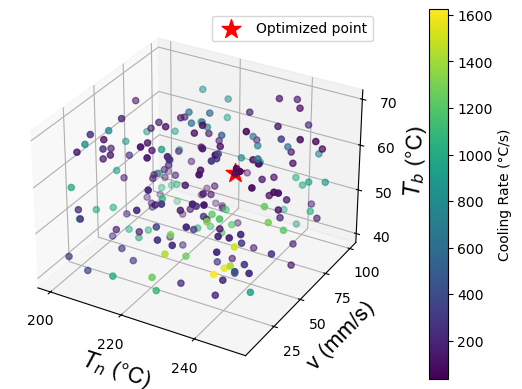

In [33]:
# Plotting the 3D scatter plot with color map and the optimized point
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#final_data=data = np.concatenate((x_train, y_train), axis=1)
# Scatter plot of the sampling points colored by the y_train values
sc = ax.scatter(opt_data[100:, 0], opt_data[100:, 1], opt_data[100:, 2], c=opt_data[100:,4], cmap='viridis')

# Add a colorbar to indicate the range of y_train values
plt.colorbar(sc, ax=ax, label='Cooling Rate (°C/s)', pad =0.1)

# Draw a star on the optimized point
optimized_point = opt_data[-1]  # The last point is the optimized point
ax.scatter(optimized_point[0], optimized_point[1], optimized_point[2], color='red', marker='*', s=200, label='Optimized point')
# Add labels and title
#ax.set_xlabel('X1',  labelpad=15)
#ax.set_ylabel('X2',  labelpad=15)
#ax.set_zlabel('X3',  labelpad=15)
#ax.set_title('Sampling points and optimized point')

ax.set_xlabel('$T_n$ (°C)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='x')
#plt.tick_params(direction='in', labelsize='small')
#plt.xticks(fontsize=14)
# naming the y axis
ax.set_ylabel('v (mm/s)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='y')
#plt.yticks(fontsize=14)     # To change the y-axis
# naming the z axis
ax.set_zlabel('$T_b$ (°C)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='z')

# Show legend
ax.legend()
# Display the plot
plt.show()

In [34]:
opt_data

array([[2.46923820e+02, 5.93893124e+01, 5.13876116e+01, 2.50000000e-01,
        9.58105419e+01],
       [2.15831976e+02, 1.37628223e+01, 5.25145260e+01, 1.00000000e-01,
        1.21188977e+03],
       [2.28484606e+02, 8.54438101e+01, 5.86179078e+01, 1.00000000e-01,
        9.17966807e+02],
       ...,
       [2.28480080e+02, 4.76042816e+01, 5.02455254e+01, 2.27291576e-01,
        1.23637821e+02],
       [2.24113482e+02, 6.56915639e+01, 5.08415524e+01, 2.35833601e-01,
        1.01057368e+02],
       [2.36587005e+02, 4.62127292e+01, 6.24060864e+01, 2.09830380e-01,
        1.04293148e+02]])

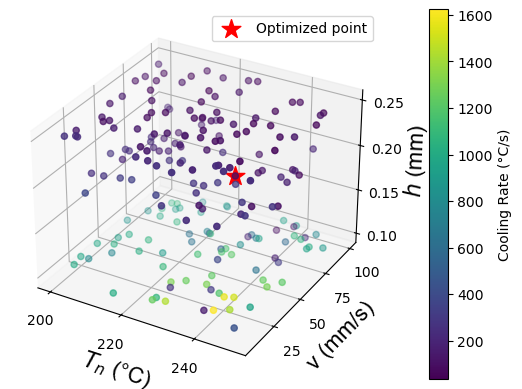

In [27]:
# Plotting the 3D scatter plot with color map and the optimized point
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#final_data=data = np.concatenate((x_train, y_train), axis=1)
# Scatter plot of the sampling points colored by the y_train values
sc = ax.scatter(opt_data[100:, 0], opt_data[100:, 1], opt_data[100:, 3], c=opt_data[100:,4], cmap='viridis')

# Add a colorbar to indicate the range of y_train values
plt.colorbar(sc, ax=ax, label='Cooling Rate (°C/s)', pad =0.1)

# Draw a star on the optimized point
optimized_point = opt_data[-1]  # The last point is the optimized point
ax.scatter(optimized_point[0], optimized_point[1], optimized_point[3], color='red', marker='*', s=200, label='Optimized point')
# Add labels and title
#ax.set_xlabel('X1',  labelpad=15)
#ax.set_ylabel('X2',  labelpad=15)
#ax.set_zlabel('X3',  labelpad=15)
#ax.set_title('Sampling points and optimized point')

ax.set_xlabel('$T_n$ (°C)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='x')
#plt.tick_params(direction='in', labelsize='small')
#plt.xticks(fontsize=14)
# naming the y axis
ax.set_ylabel('v (mm/s)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='y')
#plt.yticks(fontsize=14)     # To change the y-axis
# naming the z axis
ax.set_zlabel('$h$ (mm)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='z')

# Show legend
ax.legend()
# Display the plot
plt.show()

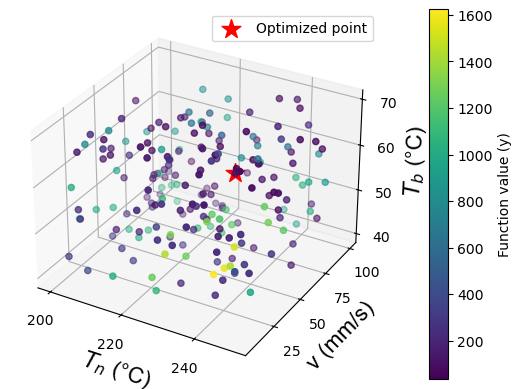

In [25]:
# Plotting the 3D scatter plot with color map and the optimized point
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#final_data=data = np.concatenate((x_train, y_train), axis=1)
# Scatter plot of the sampling points colored by the y_train values
sc = ax.scatter(opt_data[100:, 0], opt_data[100:, 1], opt_data[100:, 2], c=opt_data[100:,4], cmap='viridis')

# Add a colorbar to indicate the range of y_train values
plt.colorbar(sc, ax=ax, label='Function value (y)', pad =0.1)

# Draw a star on the optimized point
optimized_point = opt_data[-1]  # The last point is the optimized point
ax.scatter(optimized_point[0], optimized_point[1], optimized_point[2], color='red', marker='*', s=200, label='Optimized point')
# Add labels and title
#ax.set_xlabel('X1',  labelpad=15)
#ax.set_ylabel('X2',  labelpad=15)
#ax.set_zlabel('X3',  labelpad=15)
#ax.set_title('Sampling points and optimized point')

ax.set_xlabel('$T_n$ (°C)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='x')
#plt.tick_params(direction='in', labelsize='small')
#plt.xticks(fontsize=14)
# naming the y axis
ax.set_ylabel('v (mm/s)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='y')
#plt.yticks(fontsize=14)     # To change the y-axis
# naming the z axis
ax.set_zlabel('$T_b$ (°C)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='z')

# Show legend
ax.legend()
# Display the plot
plt.show()

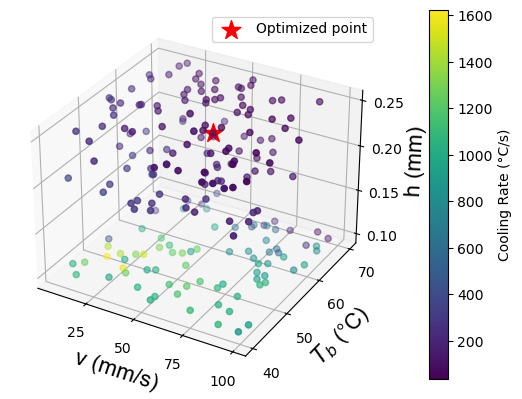

In [24]:
# Plotting the 3D scatter plot with color map and the optimized point
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#final_data=data = np.concatenate((x_train, y_train), axis=1)
# Scatter plot of the sampling points colored by the y_train values
sc = ax.scatter(opt_data[100:, 1], opt_data[100:, 2], opt_data[100:, 3], c=opt_data[100:,4], cmap='viridis')

# Add a colorbar to indicate the range of y_train values
plt.colorbar(sc, ax=ax, label='Cooling Rate (°C/s)', pad =0.1)

# Draw a star on the optimized point
optimized_point = opt_data[-1]  # The last point is the optimized point
ax.scatter(optimized_point[1], optimized_point[2], optimized_point[3], color='red', marker='*', s=200, label='Optimized point')
# Add labels and title
#ax.set_xlabel('X1',  labelpad=15)
#ax.set_ylabel('X2',  labelpad=15)
#ax.set_zlabel('X3',  labelpad=15)
#ax.set_title('Sampling points and optimized point')

ax.set_xlabel('v (mm/s)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='x')
#plt.tick_params(direction='in', labelsize='small')
#plt.xticks(fontsize=14)
# naming the y axis
ax.set_ylabel('$T_b$ (°C)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='y')
#plt.yticks(fontsize=14)     # To change the y-axis
# naming the z axis
ax.set_zlabel('h (mm)', fontsize=16, fontname='Arial')
ax.locator_params(nbins=5, axis='z')

# Show legend
ax.legend()
# Display the plot
plt.show()

In [87]:
y_train

array([ 97.78264469,  70.78298381,  94.82692837,  84.70535652,
       101.6029503 ,  89.77319428,  72.01848552,  63.07702395,
        87.39231357,  94.731986  ,  97.67991851,  94.64108641,
        88.59021596,  69.97849195,  94.9338129 ,  92.25457222,
        96.56175284,  73.72382992,  75.07311443,  60.91695655,
        59.09643196,  68.93966999,  80.85336975,  96.62657591,
        88.74204664,  54.96636751,  99.0089558 ,  85.70583364,
        52.63459972,  89.69120545,  85.0928215 ,  73.86134635,
        55.64619836,  55.10410652,  99.91357293,  70.00230335,
        89.22881732,  96.53316669,  62.39726803,  69.70064554,
        58.61919774,  78.5060854 ,  62.02536864,  85.80166459,
        95.50987673,  62.28763444,  64.10575707,  78.52668039,
        66.66735287,  94.38074805,  79.96711135,  80.96181244,
        93.11824075,  61.08151696,  70.12444603,  77.95026714,
        88.84821821,  74.18946684,  82.30845541,  94.67116989,
        80.40014523,  55.49727338,  60.7792814 ,  58.06

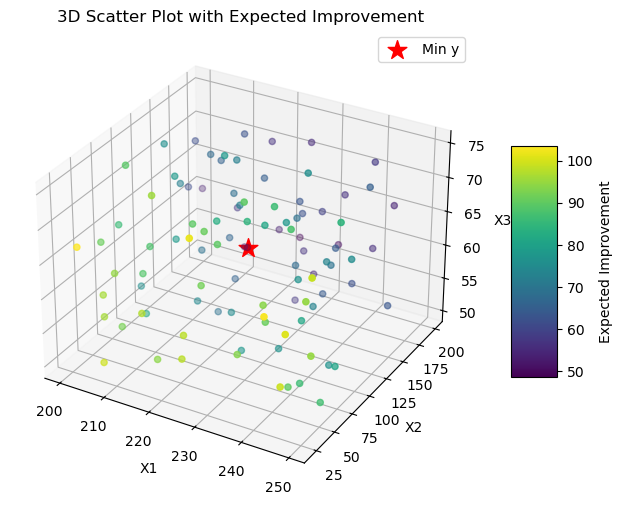

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming x[:, 0:3] is your input variables and ei is the expected improvement
# Replace x[:, 0:3] and ei with your actual data

# Find the index of the point with maximum EI
min_y = np.argmin(sample_y)
min_y_point = sample_x[min_y]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color based on EI
sc = ax.scatter(sample_x[:, 0], sample_x[:, 1], sample_x[:, 2], c=sample_y, cmap='viridis')

# Mark the point with maximum EI with a star
ax.scatter(min_y_point[0], min_y_point[1], min_y_point[2], marker='*', s=200, c='red', label='Min y')

# Add color bar
cbar = fig.colorbar(sc, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Expected Improvement')

# Set labels and title
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('3D Scatter Plot with Expected Improvement')

# Add legend
ax.legend()

plt.show()


In [64]:
# Define a Gaussian Process model (using an RBF kernel as an example)
kernel = C(1.0, (1e-10, 1e10)) * RBF(1.0, (1e-2, 1e2))
gp_model = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

# Fit the GP model with the initial training data
gp_model.fit(x_train, y_train)

GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=1),
                         n_restarts_optimizer=10)

In [65]:
new_point = optimize_acquisition_function(gp_model, bounds, y_max)
new_point
true_y_new_point = objective_function(model, new_point)
true_y_new_point.shape

(1,)

In [66]:
# Define bounds for the optimization (for each input dimension)
bounds = np.array([[220, 240], [50, 100], [60, 70]])

# Define an optimization loop
for iteration in range(10):
    # Get the current maximum of y_train
    y_max = np.max(y_train)
    
    # Optimize the acquisition function to find the next point to evaluate
    new_point = optimize_acquisition_function(gp_model, bounds, y_max)
    
    # Evaluate the true objective function at the new point
    true_y_new_point = objective_function(model, new_point)
    
    # Update `x_train` and `y_train` with the new point and its evaluated output
    x_train = np.vstack((x_train, new_point))
    y_train = np.append(y_train, true_y_new_point)
    x_train.shape
    y_train.shape
    # Update the GP model with the new data
    gp_model.fit(x_train, y_train)

# At the end of the loop, you have the optimized point and function evaluations.
print("Optimized point:", x_train[-1])
print("Function value at optimized point:", y_train[-1])

Optimized point: [221.12763989  59.24851944  64.99279773]
Function value at optimized point: 92.46253422773043
